In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import calib_camera
from calib_camera import find_obj_and_img_points, calibrate_camera
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [52]:
cv2.__version__

'3.3.1'

#### Step 1: Camera Calibration

In [1]:
# calib_camera.logger.setLevel("DEBUG")

In [3]:
nx = 9
ny = 6
images = glob.glob("camera_cal/calibration*.jpg")
pickle_file = "camera_cal/dist_pickle.p"

In [4]:
# Find object and image points and use these to calibrate the camera
objpoints, imgpoints = find_obj_and_img_points(images, nx, ny)
mtx, dist = calibrate_camera(objpoints, imgpoints, (1280, 720))

# save required variables in a pickle file
dict_pickle = dict(objpoints=objpoints, imgpoints=imgpoints, mtx=mtx, dist=dist)
pickle.dump(dict_pickle, open(pickle_file, "wb"))

2019-09-26 14:15:03,727 - CalibCamera - INFO - Found corners on 17 images
2019-09-26 14:15:04,734 - CalibCamera - INFO - Returned mtx and dist from camera calibration


#### Step 2: Undistort and transform perspective

Let's use one image as an example and transform that into a bird-eye view

In [3]:
from pipeline import perspective_transform

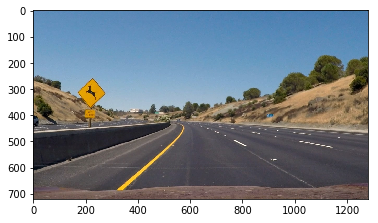

In [4]:
fnames = os.listdir("test_images")
idx = 0
fname = fnames[idx]
img = cv2.imread(os.path.join("test_images", fname))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [5]:
# first load mtx and dist
pickle_file = "camera_cal/dist_pickle.p"
dict_pickle = pickle.load(open(pickle_file, "rb"))
mtx, dist = dict_pickle["mtx"], dict_pickle["dist"]

In [132]:
# warp to birds eye-view
src = np.float32([[490, 482],
                  [810, 482],
                  [1250, 720],
                  [40, 720]])
dst = np.float32([[0, 0], 
                  [1280, 0], 
                  [1250, 720],
                  [40, 720]])

src = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right

dst = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

In [6]:
img_size = (img.shape[1], img.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])


warped_img, M = perspective_transform(img, mtx, dist, src, dst, img_size=(img.shape[1], img.shape[0]))

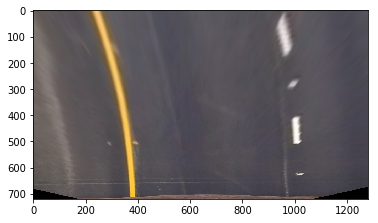

In [7]:
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))  # seems plausible

In [ ]:
# Testing undistort

# images = glob.glob('camera_cal/calibration*.jpg')
# idx = 1
# fname = images[idx]
# print(fname)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# img = cv2.imread(fname)
# dst = cv2.undistort(img, mtx, dist, None, mtx)
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=20)
# ax2.imshow(dst)
# ax2.set_title("Undistorted Image", fontsize=20)

#### Step 3: Color Thresholding

In [8]:
from pipeline import abs_sobel_thresh, dir_thresh, mag_thresh, hls_thresh

In [9]:
grad_binary = abs_sobel_thresh(warped_img, orient='x', thresh=(20, 100), sobel_kernel=3)
mag_binary = mag_thresh(warped_img, thresh=(30, 100), sobel_kernel=3)
dir_binary = dir_thresh(warped_img, thresh=(0.7, 1.3), sobel_kernel=15)
hls_binary = hls_thresh(warped_img, hls_channel="S", thresh=(90, 255))
assert grad_binary.shape == mag_binary.shape == dir_binary.shape == hls_binary.shape == warped_img.shape[:2] 

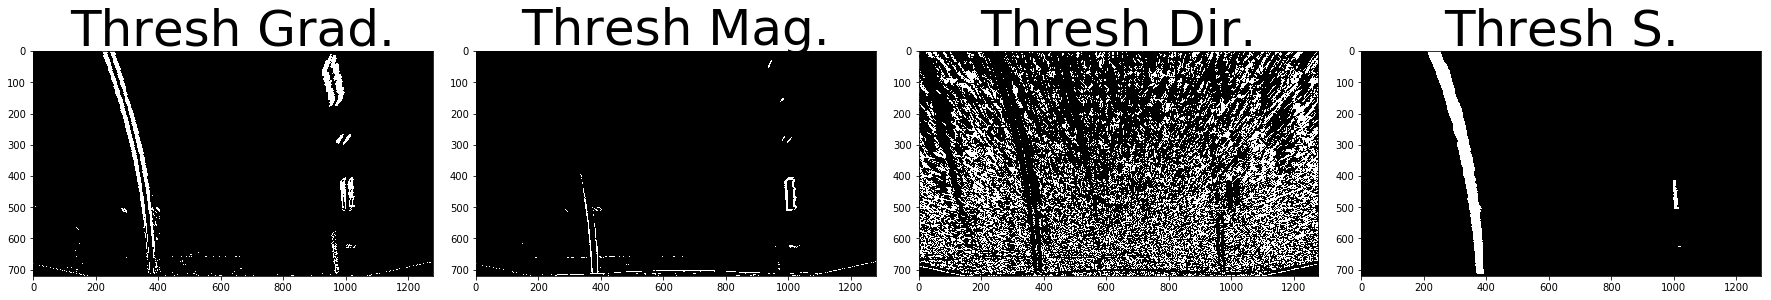

In [10]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(grad_binary, cmap="gray")
ax1.set_title('Thresh Grad.', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresh Mag.', fontsize=50)
ax3.imshow(dir_binary, cmap='gray')
ax3.set_title('Thresh Dir.', fontsize=50)
ax4.imshow(hls_binary, cmap='gray')
ax4.set_title('Thresh S.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
# Combine thresholds
combined_binary = np.zeros_like(dir_binary)
combined_binary[(hls_binary == 1) | ((grad_binary == 1) | ((mag_binary == 1) & (dir_binary == 1)))] = 1
# combined_binary[(hls_binary == 1) | (mag_binary == 1)] = 1
combined_binary[(hls_binary == 1) | ( ((mag_binary == 1) & (dir_binary == 1)))] = 1

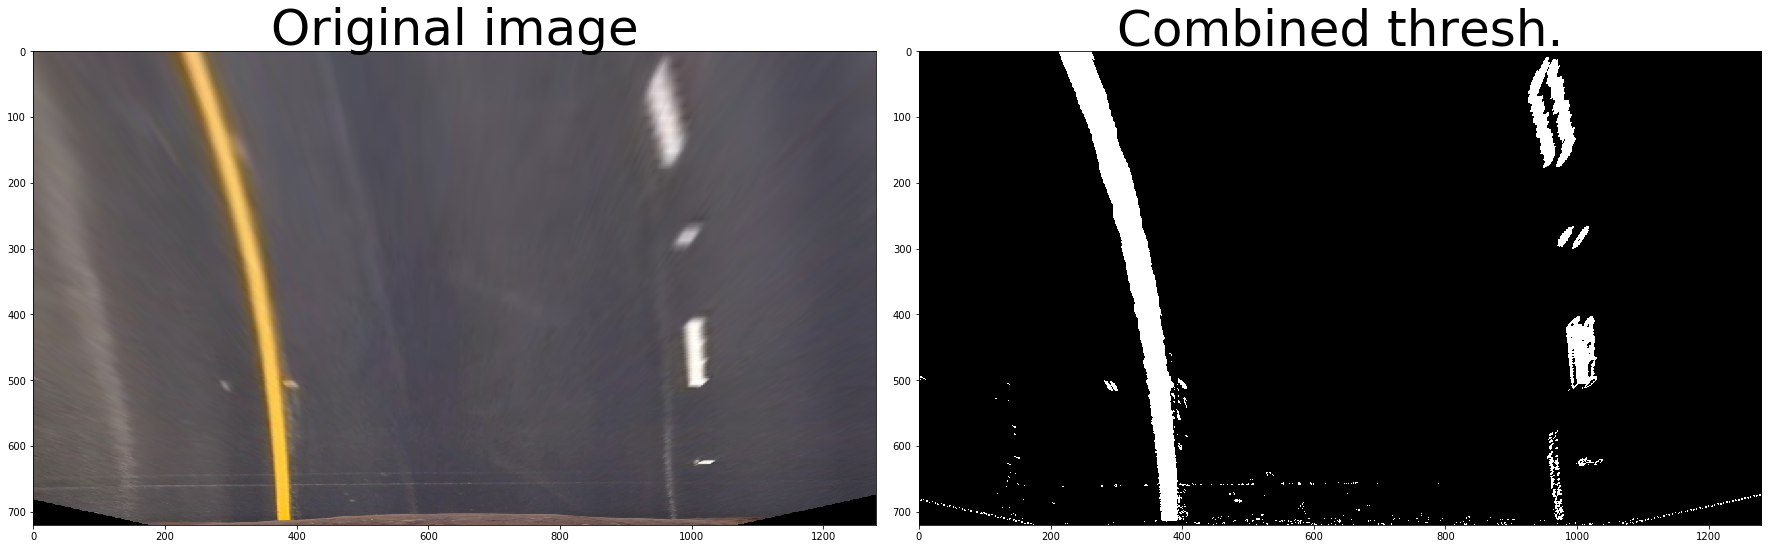

In [12]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined thresh.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Step 4: Find lane lines

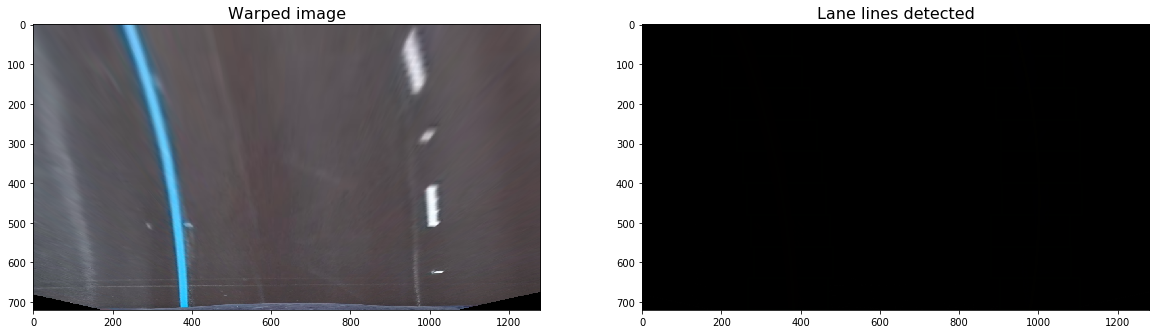

In [49]:
def get_histogram(img):
    return np.sum(img[img.shape[0]//2:, :], axis=0)
def detect_lines(img, return_img=False):
    # Take a histogram of the bottom half of the image
    histogram = get_histogram(img)

    if return_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw left and right lines
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

lines_fit, left_points, right_points, out_img = detect_lines(combined_binary, return_img=True)

# Plot the results
plt_images(warped_img, 'Warped image', np.float32(out_img), 'Lane lines detected')


In [36]:
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')

In [37]:
from pipeline import hist, find_lane_pixels, search_around_poly, fit_poly, fit_polynomial

In [38]:
# lets do it step by step
binary_warped = combined_binary
histogram = hist(binary_warped) # sum over pixel values of bottom half image -> peaks indicate lines
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) # create output image to draw on (not necessary)
midpoint = np.int(histogram.shape[0]//2)  # 640
leftx_base = np.argmax(histogram[:midpoint])  # find index of left peak (indicates ll)
rightx_base = np.argmax(histogram[midpoint:]) + midpoint # find index of right peak (indicates rl)
nwindows = 9
margin = 100
minpix = 50
window_height = np.int(binary_warped.shape[0]//nwindows)  # 80
nonzero = binary_warped.nonzero()  # a tuple for x and y
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftx_current = leftx_base
rightx_current = rightx_base
left_lane_inds = []
right_lane_inds = []
for window in range(nwindows):  # index 0 to 8
    win_y_low = binary_warped.shape[0] - (window+1)*window_height  
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) # bottom left to top right, in green, with thickness 2
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & 
            (nonzeroy >= win_y_low ) & (nonzeroy < win_y_high)).nonzero()[0]
    good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & 
        (nonzeroy >= win_y_low ) & (nonzeroy < win_y_high)).nonzero()[0]
    left_lane_inds.append(good_left_inds)  # indices
    right_lane_inds.append(good_right_inds)
    if len(good_left_inds) > minpix:
        leftx_current = int(np.mean(nonzerox[good_left_inds]))
        # print(leftx_current)
    if len(good_right_inds) > minpix:
        rightx_current = int(np.mean(nonzerox[good_right_inds]))

left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

left_fit = np.polyfit(leftx, lefty, deg=2)
right_fit = np.polyfit(rightx, righty, deg=2)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
for index in range(binary_warped.shape[0]):
    cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
    cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))

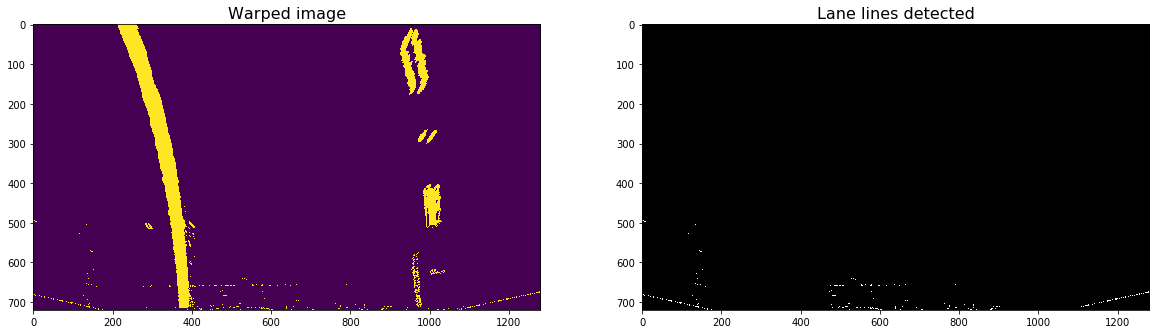

In [42]:
plt_images(binary_warped, 'Warped image', out_img, 'Lane lines detected')

In [41]:
left_fitx

array([  1.13143878e+02,   1.09988583e+02,   1.06856520e+02,
         1.03747690e+02,   1.00662091e+02,   9.75997247e+01,
         9.45605906e+01,   9.15446886e+01,   8.85520189e+01,
         8.55825813e+01,   8.26363758e+01,   7.97134026e+01,
         7.68136615e+01,   7.39371526e+01,   7.10838759e+01,
         6.82538313e+01,   6.54470190e+01,   6.26634388e+01,
         5.99030908e+01,   5.71659749e+01,   5.44520913e+01,
         5.17614398e+01,   4.90940205e+01,   4.64498334e+01,
         4.38288784e+01,   4.12311557e+01,   3.86566651e+01,
         3.61054067e+01,   3.35773804e+01,   3.10725864e+01,
         2.85910245e+01,   2.61326948e+01,   2.36975973e+01,
         2.12857319e+01,   1.88970987e+01,   1.65316977e+01,
         1.41895289e+01,   1.18705923e+01,   9.57488782e+00,
         7.30241553e+00,   5.05317542e+00,   2.82716749e+00,
         6.24391737e-01,  -1.55515184e+00,  -3.71146324e+00,
        -5.84454246e+00,  -7.95438951e+00,  -1.00410044e+01,
        -1.21043871e+01,

In [30]:
def detect_lines(img, return_img=False):
    # Take a histogram of the bottom half of the image
    histogram = hist(img)

    if return_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw left and right lines
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

In [31]:
lines_fit, left_points, right_points, out_img = detect_lines(binary_warped, return_img=True)

# Plot the results
# plt_images(warped_img, 'Warped image', out_img, 'Lane lines detected')

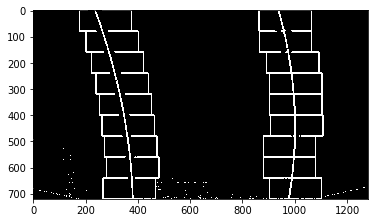

In [28]:
plt.imshow(np.float32(out_img[:,:,1]), cmap="gray")

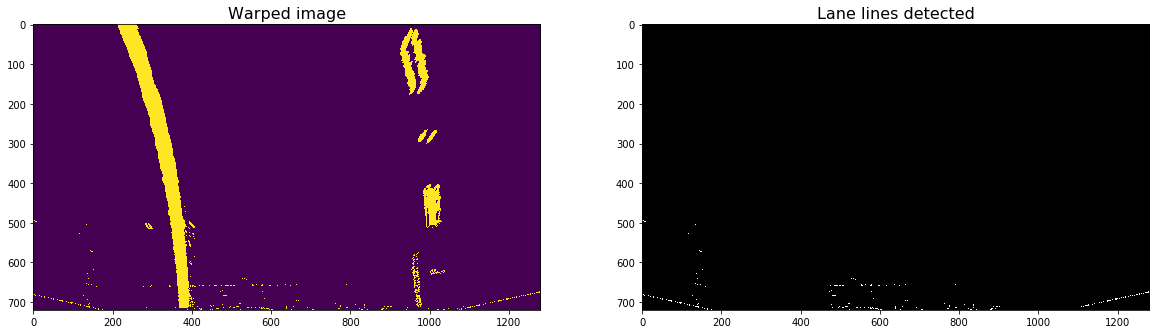

In [67]:
# Plot the results
plt_images(binary_warped, 'Warped image', out_img, 'Lane lines detected')

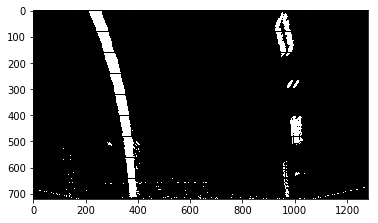

In [48]:
plt.imshow(out_img, cmap="gray")

In [ ]:


    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(leftx, lefty, deg=2)
    right_fit = np.polyfit(rightx, righty, deg=2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox >= left_fit[0]*nonzeroy**2 + 
        left_fit[1]*nonzeroy + left_fit[2] - margin) & 
        (nonzerox < left_fit[0]*nonzeroy**2 + 
        left_fit[1]*nonzeroy + left_fit[2] + margin)).nonzero()[0]
    right_lane_inds = ((nonzerox >= right_fit[0]*nonzeroy**2 + 
        right_fit[1]*nonzeroy + right_fit[2] - margin) & 
        (nonzerox < right_fit[0]*nonzeroy**2 + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result


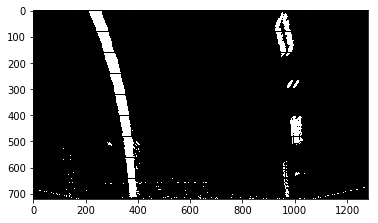

In [26]:
# out_img = fit_polynomial(combined_binary)
plt.imshow(out_img)

In [164]:
out_img.shape

(720, 1280, 3)

In [155]:
left_fit = np.polyfit(leftx, lefty, deg=2)
right_fit = np.polyfit(rightx, righty, deg=2)
ploty = np.linspace(0, binary_warped.shape[1]-1, binary_warped.shape[1] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]


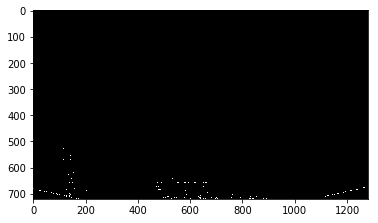

In [157]:
plt.imshow(out_img)

In [121]:
binary_warped = warped_img
margin = 100

# Grab activated pixels
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

nonzeroy

array([  0,   0,   0, ..., 719, 719, 719])

In [126]:
margin = 100

# Grab activated pixels
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

### TO-DO: Set the area of search based on activated x-values ###
### within the +/- margin of our polynomial function ###
### Hint: consider the window areas for the similarly named variables ###
### in the previous quiz, but change the windows to our new search area ###
left_lane_inds = ((nonzerox >= left_fit[0]*nonzeroy**2 + 
    left_fit[1]*nonzeroy + left_fit[2] - margin) & 
    (nonzerox < left_fit[0]*nonzeroy**2 + 
    left_fit[1]*nonzeroy + left_fit[2] + margin)).nonzero()[0]
right_lane_inds = ((nonzerox >= right_fit[0]*nonzeroy**2 + 
    right_fit[1]*nonzeroy + right_fit[2] - margin) & 
    (nonzerox < right_fit[0]*nonzeroy**2 + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)).nonzero()[0]

# Again, extract left and right line pixel positions
leftx_new = nonzerox[left_lane_inds]
lefty_new = nonzeroy[left_lane_inds] 
rightx_new = nonzerox[right_lane_inds]
righty_new = nonzeroy[right_lane_inds]

# Fit new polynomials
left_fitx_new, right_fitx_new, ploty = fit_poly(binary_warped.shape, leftx_new, lefty_new, rightx_new, righty_new)

